In [1]:
import torch
import argparse
from omegaconf import OmegaConf

from torch.utils.data.dataloader import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
import data_process  as Data_process

import torch.optim as optim

from utils.wandb_setting import wandb_setting
from utils.seed_setting import seed_setting
from tqdm.auto import tqdm
import pandas as pd

tokenizer = AutoTokenizer.from_pretrained('microsoft/layoutlmv2-base-uncased', use_fast=True)
train_data = load_dataset('Trailblazer-Yoo/boostcamp-docvqa', split='train')
val_data = load_dataset('Trailblazer-Yoo/boostcamp-docvqa', split='val')
test_data = load_dataset('Trailblazer-Yoo/boostcamp-docvqa-test', split='test')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
count  = 0
indices_train = []
input_ids = []
decode = []
difference = []
for idx,data in enumerate(tqdm(train_data)):
    tokenized_sentences = tokenizer(
        [data['question']],
        [data['words']],
        [data['boxes']],
        truncation="only_second",  # max_seq_length까지 truncate한다. pair의 두번째 파트(context)만 잘라냄.
        max_length=512,
        return_token_type_ids=True, # BERT 모델일 경우에만 반환
        return_overflowing_tokens=True, # (List[int]) : 여러개로 쪼갠 문장들이 하나의 같은 context라는 것을 나타내주는 리스트, batch 단위일때 사용합니다.
        return_offsets_mapping=True,  # 각 토큰에 대해 (char_start, char_end) 정보를 반환한 것인지
    )
    if len(tokenized_sentences['input_ids'][0]) > 511:
        d = tokenizer.decode(tokenized_sentences['input_ids'][0])
        try:
            tmp = d.rindex('source : https :')
        except:
            indices_train.append(idx)
            input_ids.append(tokenized_sentences['input_ids'][0])
            decode.append(d)
            text = ' '.join(data['words']).lower()
            difference.append(text[text.rfind(' '.join(d.split()[-4:-1])):])
            
df_train = pd.DataFrame({'indices':indices_train,
                        'input_ids':input_ids,
                        'decode':decode,
                        'difference':difference
                    })
df_train.head()

100%|██████████| 39463/39463 [47:37<00:00, 13.81it/s] 


,indices,input_ids,decode,difference
0,13,"[101, 2029, 3231, 2003, 2109, 2000, 16157, 239...",[CLS] which test is used to evaluate art menth...,in progress. 2022156205 source: https://www.in...
1,14,"[101, 2054, 2003, 1996, 3395, 1997, 1996, 6254...",[CLS] what is the subject of the document / le...,7
2,24,"[101, 5825, 1997, 1996, 6254, 1029, 102, 1012,...",[CLS] heading of the document? [SEP]. '.. - 7 ...,7
3,25,"[101, 2073, 2001, 1996, 3034, 2218, 1029, 102,...",[CLS] where was the conference held? [SEP]. '....,7
4,26,"[101, 2129, 2116, 5664, 10595, 3711, 2000, 237...",[CLS] how many distinct mechanisms appear to p...,might exert comco . 3601a chapman highway . is...


<AxesSubplot: >

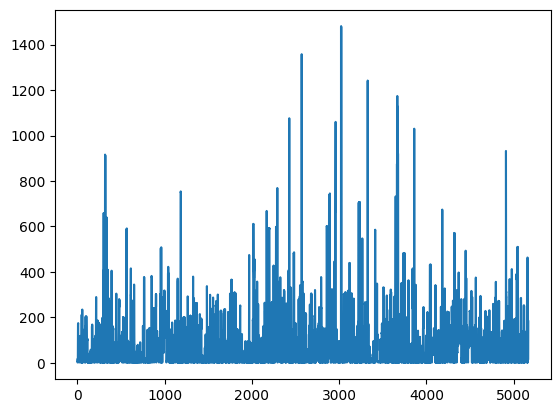

In [37]:
df_train['len'] = df_train['difference'].apply(lambda x: len(x.split()))
df_train['len'].plot()

In [32]:
count  = 0
indices_val = []
input_ids = []
decode = []
difference = []
for idx,data in enumerate(tqdm(val_data)):
    tokenized_sentences = tokenizer(
        [data['question']],
        [data['words']],
        [data['boxes']],
        truncation="only_second",  # max_seq_length까지 truncate한다. pair의 두번째 파트(context)만 잘라냄.
        max_length=512,
        return_token_type_ids=True, # BERT 모델일 경우에만 반환
        return_overflowing_tokens=True, # (List[int]) : 여러개로 쪼갠 문장들이 하나의 같은 context라는 것을 나타내주는 리스트, batch 단위일때 사용합니다.
        return_offsets_mapping=True,  # 각 토큰에 대해 (char_start, char_end) 정보를 반환한 것인지
    )
    if len(tokenized_sentences['input_ids'][0]) > 511:
        d = tokenizer.decode(tokenized_sentences['input_ids'][0])
        try:
            tmp = d.rindex('source : https :')
        except:
            indices_val.append(idx)
            input_ids.append(tokenized_sentences['input_ids'][0])
            decode.append(d)
            text = ' '.join(data['words']).lower()
            difference.append(text[text.rfind(' '.join(d.split()[-4:-1])):])
            
df_val = pd.DataFrame({'indices':indices_val,
                        'input_ids':input_ids,
                        'decode':decode,
                        'difference':difference
                    })
df_val.head()

100%|██████████| 5349/5349 [06:26<00:00, 13.84it/s]


,indices,input_ids,decode,difference
0,34,"[101, 2040, 2001, 1996, 2472, 2383, 1996, 3284...",[CLS] who was the director having the highest ...,"schemes. s. b. mathur 2,91,000 10.000 composit..."
1,35,"[101, 2054, 2003, 1996, 2053, 1012, 1997, 7047...",[CLS] what is the no. of options held by s. h....,"stock option schemes. s. b. mathur 2,91,000 10..."
2,36,"[101, 2054, 2003, 1996, 2053, 1012, 1997, 6623...",[CLS] what is the no. of ordinary shares held ...,000 company's employee stock option schemes. s...
3,38,"[101, 2054, 2003, 1996, 2053, 1012, 1997, 6623...",[CLS] what is the no. of ordinary shares held ...,"stock option schemes. s. b. mathur 2,91,000 10..."
4,99,"[101, 2054, 2003, 1996, 2516, 1997, 1996, 6254...",[CLS] what is the title of the document? [SEP]...,new jersey 08540 . 609/924-1116 . fax: 609/924...


In [34]:
df_val['len'] = df_val['difference'].apply(lambda x: len(x.split()))
df_val.head()

,indices,input_ids,decode,difference,len
0,34,"[101, 2040, 2001, 1996, 2472, 2383, 1996, 3284...",[CLS] who was the director having the highest ...,"schemes. s. b. mathur 2,91,000 10.000 composit...",166
1,35,"[101, 2054, 2003, 1996, 2053, 1012, 1997, 7047...",[CLS] what is the no. of options held by s. h....,"stock option schemes. s. b. mathur 2,91,000 10...",168
2,36,"[101, 2054, 2003, 1996, 2053, 1012, 1997, 6623...",[CLS] what is the no. of ordinary shares held ...,000 company's employee stock option schemes. s...,171
3,38,"[101, 2054, 2003, 1996, 2053, 1012, 1997, 6623...",[CLS] what is the no. of ordinary shares held ...,"stock option schemes. s. b. mathur 2,91,000 10...",168
4,99,"[101, 2054, 2003, 1996, 2516, 1997, 1996, 6254...",[CLS] what is the title of the document? [SEP]...,new jersey 08540 . 609/924-1116 . fax: 609/924...,16


<AxesSubplot: >

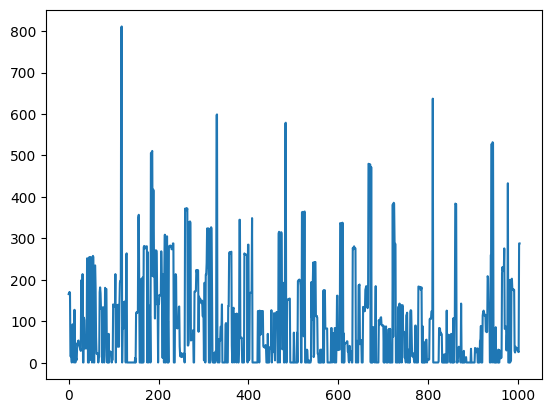

In [35]:
df_val['len'].plot()

In [43]:
count  = 0
indices_test = []
input_ids = []
decode = []
difference = []
for idx,data in enumerate(tqdm(test_data)):
    tokenized_sentences = tokenizer(
        [data['question']],
        [data['words']],
        [data['boxes']],
        truncation="only_second",  # max_seq_length까지 truncate한다. pair의 두번째 파트(context)만 잘라냄.
        max_length=512,
        return_token_type_ids=True, # BERT 모델일 경우에만 반환
        return_overflowing_tokens=True, # (List[int]) : 여러개로 쪼갠 문장들이 하나의 같은 context라는 것을 나타내주는 리스트, batch 단위일때 사용합니다.
        return_offsets_mapping=True,  # 각 토큰에 대해 (char_start, char_end) 정보를 반환한 것인지
    )
    if len(tokenized_sentences['input_ids'][0]) > 511:
        d = tokenizer.decode(tokenized_sentences['input_ids'][0])
        try:
            tmp = d.rindex('source : https :')
        except:
            indices_test.append(idx)
            input_ids.append(tokenized_sentences['input_ids'][0])
            decode.append(d)
            text = ' '.join(data['words']).lower()
            difference.append(text[text.rfind(' '.join(d.split()[-4:-1])):])
            
df_test = pd.DataFrame({'indices':indices_test,
                        'input_ids':input_ids,
                        'decode':decode,
                        'difference':difference
                    })

100%|██████████| 5188/5188 [06:12<00:00, 13.94it/s]


<AxesSubplot: >

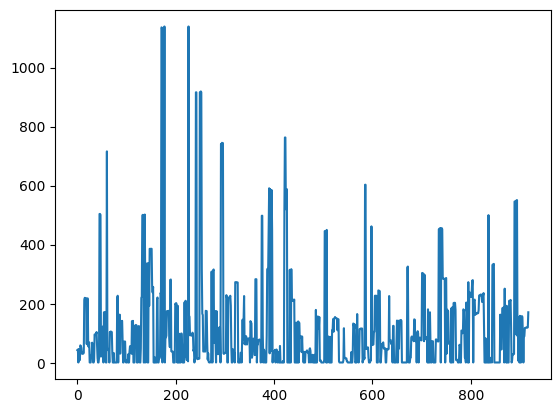

In [44]:
df_test['len'] = df_test['difference'].apply(lambda x: len(x.split()))
df_test['len'].plot()